In [134]:
import numpy as np
from scipy.io import loadmat
import scipy.misc
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import OneHotEncoder

In [ ]:
input_layer_size  = 400 # % 20x20 Input Images of Digits
hidden_layer_size = 25 #   % 25 hidden units
num_labels = 10

In [111]:
data = loadmat('ex4data1', mat_dtype=True)
X_orig = data['X']
X = ((X_orig-X_orig[:].min(axis = 1).reshape(m,1))/(X_orig[:].max(axis = 1)-X_orig[:].min(axis = 1)).reshape(m,1)*255).astype(int)
y = data['y']
m = X.shape[0]

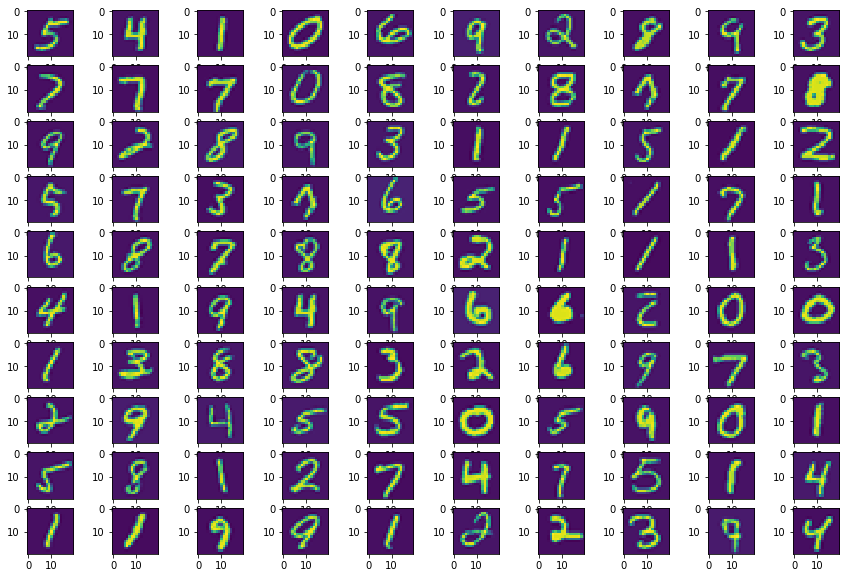

In [112]:
indicies = np.random.choice(np.arange(m), 100)

cols,ros=10,10
fig, ax  = plt.subplots(rows,cols, figsize=[15,10])
for i in range(rows):
    for j in range(cols):
        ax[i,j].imshow(scipy.misc.toimage(X[indicies[i*cols+j]].reshape(20,20).T))
plt.show()

In [107]:
weights_file = loadmat('ex4weights.mat', mat_dtype=True)

In [113]:
Theta1_orig, Theta2_orig = weights_file['Theta1'], weights_file['Theta2']

In [122]:
def sigmoid(x, theta):
    return 1/(1+np.e**x.dot(theta))

In [126]:
sigmoid(X_orig[400], Theta1_orig[0,1:])

0.99132728414988125

In [121]:
X_orig[0].shape

(400,)

In [131]:
def perdict(X, theta1, theta2):
    IL = np.insert(X, 0, 1, axis=1)
    HL = sigmoid(IL, theta1.T)
    HL = np.insert(HL, 0, 1, axis=1)
    OL = sigmoid(HL, theta2.T)
    return (np.argmax((OL), axis=1) + 1).reshape(OL.shape[0],1)

In [132]:
p = perdict(X_orig, Theta1_orig, Theta2_orig)

In [133]:
np.mean(p==y)

0.56059999999999999

In [135]:
encoder = OneHotEncoder()

In [139]:
y_oh = encoder.fit_transform(y).toarray()

In [194]:
def ff_nn(X, theta1, theta2):
    X_bias = np.insert(X,0,1,axis=1) #np.append(1,X, axis=1) #add axis condition
    IL = sigmoid(X_bias, theta1.T)
    IL = np.insert(IL,0,1,axis=1) # np.append(1, IL, axis=1)   #add axis condition
    OL = sigmoid(IL, theta2.T)
    return OL

In [213]:
ff_res = ff_nn(X_orig, Theta1_orig, Theta2_orig)

In [219]:
def costFunc(X,y,theta1,theta2):
    predicted = ff_nn(X, theta1, theta2)
    print((y-predicted).sum())

In [220]:
costFunc(X_orig, y_oh, Theta1_orig, Theta2_orig)

-36061.5326066
